# Make Photoz test input from VIDEO SXDS data

This notebook uses the HELP python environment to make a eazy-pype input catalogue:

https://github.com/H-E-L-P/herschelhelp_internal

To make the photoz inputs we must merge in the spectroscopic redshifts and make some trivial catalogue changes. We then need to make configuration inputs for the photoz code. This includes downloading filter response curves.

Installation and running of the EAZY based code is described here:

https://github.com/dunkenj/eazy-pype/

This is an early test on the catalogues as part of our validation process.



In [1]:
# What version of the Stack are we using?
! eups list -s | grep lsst_distrib
! eups list -s | grep obs_vista

lsst_distrib          g2d4714e03a+6e1aa0b536 	current w_latest w_2022_07 setup
obs_vista             23.0.0-1   	current setup


In [2]:

%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))
from herschelhelp.filters import correct_galactic_extinction
from herschelhelp.external import convert_table_for_cigale
from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge
from herschelhelp_internal.utils import coords_to_hpidx, ebv, gen_help_id, inMoc, mag_to_flux

import numpy as np
import os
import time

from astropy.time import Time
from astropy.table import Table
import astropy.units as u
from astropy.coordinates import SkyCoord

/Users/raphaelshirley/miniconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/raphaelshirley/miniconda3/envs/herschelhelp_internal/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/Users/raphaelshirley/miniconda3/envs/herschelhelp_internal/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/raphaelshirley/miniconda3/envs/herschelhelp_internal/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam wa

In [99]:
#SUFFIX = os.environ.get('SUFFIX', time.strftime("%Y%m%d"))
SUFFIX=Time.now().isot.replace(':','').replace('-','')[:-4]

In [100]:
SUFFIX

'20220802T124445'

In [5]:
!mkdir figs

mkdir: figs: File exists


In [59]:
!ls ../../dmu5/dmu5_VIDEO/data/

3.0_startCoadd.slurm.e58711243
39
48
66
8523_5,2_reducedCat.fits
VSA_Ks_6.fits
calexp-HSC-R-8524-2,7.fits
calexp-VISTA-Y-8524-2,7.fits
deepCoadd_calexp_8524_48_K_hscPdr2_u_ir-shir1_DRP_videoCoaddDetect_20220405T133706Z.fits
deepCoadd_calexp_8524_48_K_hscPdr2_u_ir-shir1_DRP_videoCoadd_20220411T145237Z.fits
example
full_reduced_cat_SXDS_20220802.fits
full_reduced_cat_SXDS_p2021_1.fits
full_reduced_cat_SXDS_p2021_1_20210702.fits
full_reduced_cat_SXDS_p2022.1_20220428.fits
full_reduced_cat_SXDS_p2022.1_20220721.fits.gz
u_ir-shir1_DRP_singleFrame_20220317T193549Z_2022-03-17_21:12.png
u_ir-shir1_DRP_videoCoadd_20220407T164547Z_2022-04-07_18:40.png
u_ir-shir1_DRP_videoCoadd_20220411T145237Z_2022-04-11_16:55.png
u_ir-shir1_DRP_videoCoadd_20220411T145237Z_2022-04-13_16:09.png
u_ir-shir1_DRP_videoMultiVisit3_20220420T134201Z_2022-04-20_14:49.png


In [61]:
#p2021.1
#version='p2021.1'
version='p2022p3'
infile='../../dmu5/dmu5_VIDEO/data/full_reduced_cat_SXDS_20220802.fits'

hsc_bands = 'GRIZY'
vista_bands = 'ZYJHK'# removing ZY for now
bands = ['HSC_{}'.format(b) for b in hsc_bands]
bands += ['VIRCAM_{}'.format(b) for b in vista_bands]
cols = ['id', 'VIRCAM_Ks_m_coord_ra','VIRCAM_Ks_m_coord_dec','VIRCAM_Ks_m_detect_isPrimary']
cols+=['{}_m_base_CircularApertureFlux_6_0_flux'.format(b.replace('K','Ks')) for b in bands]
cols+=['{}_m_base_CircularApertureFlux_6_0_fluxErr'.format(b.replace('K','Ks'))  for b in bands]
cat = Table.read(infile)[cols]
cat['ra']=cat['VIRCAM_Ks_m_coord_ra'] #.name='ra'
cat['dec']=cat['VIRCAM_Ks_m_coord_dec'] #.name='dec'

for c in cat.colnames:
    cat[c].name=c.replace('VISTA','VIRCAM')

In [62]:
#From email from Manda
oxfordApCorr = {
    'HSC_G_2as':0.1765,
    'HSC_G_3as':0.0788,
    'HSC_R_2as':0.1638,
    'HSC_R_3as':0.0905,
    'HSC_I_2as':0.1512,
    'HSC_I_3as':0.0788,
    'HSC_Z_2as':0.2155,
    'HSC_Z_3as':0.1144,
    'HSC_Y_2as':0.2023,
    'HSC_Y_3as':0.1144,
    'VIRCAM_Z_2as':0.3567,
    'VIRCAM_Z_3as':0.2023,
    'VIRCAM_Y_2as':0.3567,
    'VIRCAM_Y_3as':0.2023,
    'VIRCAM_J_2as':0.2980,
    'VIRCAM_J_3as':0.1765,
    'VIRCAM_H_2as':0.2423,
    'VIRCAM_H_3as':0.1512,
    'VIRCAM_Ks_2as':0.2288,
    'VIRCAM_Ks_3as':0.1388}

In [63]:
for c in cat.colnames:
    if c.endswith('_mag'):
        #print(c)
        physical_filter='{}_{}'.format(c.split('_')[0],c.split('_')[1])
        #print(np.nanmedian(test_cat[c]))
        #Following correction once to fix issue with calibrators and twice to apply apperture corrections!
        if version=='p2021.1':
            cat[c]-=2*oxfordApCorr['{}_2as'.format(physical_filter)]
        elif version=='p2022p3':
            cat[c]-=1*oxfordApCorr['{}_2as'.format(physical_filter)]
        #print(np.nanmedian(test_cat[c]))
        #cat[c.replace('mag','flux')],cat[c.replace('mag','fluxErr')]=mag_to_flux(
         #   cat[c],cat[c.replace('mag','magErr')])
        
    if c.endswith('_flux') or c.endswith('_fluxErr'):
        #print(c)
        physical_filter='{}_{}'.format(c.split('_')[0],c.split('_')[1])
        #print(np.nanmedian(test_cat[c]))
        #Following correction once to fix issue with calibrators and twice to apply apperture corrections!
        if 'HSC' in physical_filter:
            cat[c]*=10**(1*oxfordApCorr['{}_2as'.format(physical_filter)]/2.5)
            print(c,physical_filter,oxfordApCorr['{}_2as'.format(physical_filter)])
        elif 'VIRCAM' in physical_filter:
            cat[c]*=10**(1*oxfordApCorr['{}_2as'.format(physical_filter)]/2.5)
            print(c,physical_filter,2*oxfordApCorr['{}_2as'.format(physical_filter)])
                                                                                             

HSC_G_m_base_CircularApertureFlux_6_0_flux HSC_G 0.1765
HSC_R_m_base_CircularApertureFlux_6_0_flux HSC_R 0.1638
HSC_I_m_base_CircularApertureFlux_6_0_flux HSC_I 0.1512
HSC_Z_m_base_CircularApertureFlux_6_0_flux HSC_Z 0.2155
HSC_Y_m_base_CircularApertureFlux_6_0_flux HSC_Y 0.2023
VIRCAM_Z_m_base_CircularApertureFlux_6_0_flux VIRCAM_Z 0.7134
VIRCAM_Y_m_base_CircularApertureFlux_6_0_flux VIRCAM_Y 0.7134
VIRCAM_J_m_base_CircularApertureFlux_6_0_flux VIRCAM_J 0.596
VIRCAM_H_m_base_CircularApertureFlux_6_0_flux VIRCAM_H 0.4846
VIRCAM_Ks_m_base_CircularApertureFlux_6_0_flux VIRCAM_Ks 0.4576
HSC_G_m_base_CircularApertureFlux_6_0_fluxErr HSC_G 0.1765
HSC_R_m_base_CircularApertureFlux_6_0_fluxErr HSC_R 0.1638
HSC_I_m_base_CircularApertureFlux_6_0_fluxErr HSC_I 0.1512
HSC_Z_m_base_CircularApertureFlux_6_0_fluxErr HSC_Z 0.2155
HSC_Y_m_base_CircularApertureFlux_6_0_fluxErr HSC_Y 0.2023
VIRCAM_Z_m_base_CircularApertureFlux_6_0_fluxErr VIRCAM_Z 0.7134
VIRCAM_Y_m_base_CircularApertureFlux_6_0_fluxErr 

In [64]:
for b in bands:
    b=b.replace('VISTA','VIRCAM').replace('_K','_Ks')
    print(b)
    
    flux_col="{}_m_base_CircularApertureFlux_6_0_flux".format(b.replace('VISTA','VIRCAM'))
    err_col=flux_col+"Err"
    bad_meas=cat[flux_col]>1e10
    bad_meas|=cat[err_col]>1e10
    bad_meas|=cat[flux_col]<-1e10
    bad_meas|=cat[err_col]<-1e10
    print(np.sum(bad_meas),len(bad_meas))
    cat[flux_col][bad_meas]=np.nan
    cat[err_col][bad_meas]=np.nan
    
    #Try recalibrating errors
    if 'VIRCAM' in b:
        cat[err_col]*=4

HSC_G
0 4739126
HSC_R
0 4739126
HSC_I
0 4739126
HSC_Z
0 4739126
HSC_Y
0 4739126
VIRCAM_Z
5 4739126
VIRCAM_Y
0 4739126
VIRCAM_J
0 4739126
VIRCAM_H
0 4739126
VIRCAM_Ks
0 4739126


In [65]:
# #Rename to CIGALE/HELP format
# for c in cat.colnames:
#     if c.endswith('m_base_CircularApertureFlux_6_0_flux'):
#         mask = cat[c]>1e10
#         cat[c][mask]=np.nan
#         f_name='{}_{}_flux'.format(
#             c.split('_')[0].lower(),#.replace('hsc','suprime'),
#             c.split('_')[1].lower()
#         )
#         cat[c].name=f_name
#         cat[f_name]=cat[f_name].to(u.uJy)
#     if c.endswith('m_base_CircularApertureFlux_6_0_fluxErr'):
#         mask = cat[c]>1e10
#         cat[c][mask]=np.nan
#         ferr_name='{}_{}_fluxerr'.format(
#             c.split('_')[0].lower(),#.replace('hsc','suprime'),
#             c.split('_')[1].lower()
#         )
#         cat[c].name=ferr_name
#         cat[ferr_name]=cat[ferr_name].to(u.uJy)

In [66]:
mask = (cat['ra']<1e10) | (cat['dec']<1e10)
mask&=cat['VIRCAM_Ks_m_detect_isPrimary']==1
#mask&=(cat['hsc_i_flux']/cat['hsc_i_fluxerr'] > 5)
#mask&=(cat['vista_ks_flux']/cat['vista_ks_fluxerr'] > 5)
cat = cat[mask]
    
cat['ra']=cat['ra'].to(u.deg)
cat['dec']=cat['dec'].to(u.deg)


In [67]:
#cat['zspec'].name='z_spec'

## Merge Specz

In [69]:
specz=Table.read('./data/XMM-LSS-specz-v2.91.fits.gz')
for c in specz.colnames:
    specz[c].name=c.lower()
specz['objid'].name='specz_id'

In [70]:
len(specz)

127682

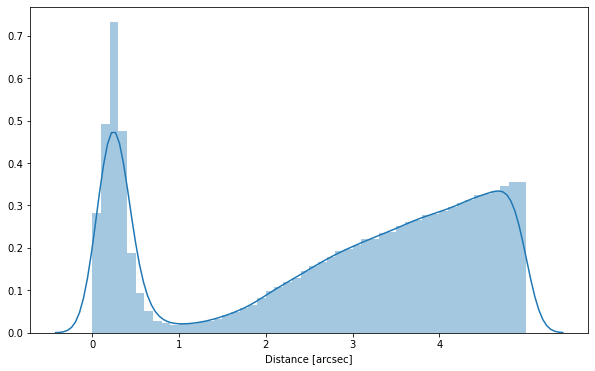

In [71]:
nb_merge_dist_plot(
    SkyCoord(cat['ra'], cat['dec']),
    SkyCoord(specz['ra'] * u.deg, specz['dec'] * u.deg)
)

In [72]:
cat = specz_merge(cat, specz, radius=1. * u.arcsec)

In [73]:
#cat=cat[cat['specz_id']!='']
#cat['redshift']=cat['zspec']

In [74]:
#Replace nans with -99
cat['zspec'].name='z_spec'
cat['z_spec'][np.isnan(cat['z_spec'])]=-99

In [75]:
#remove spaces from specz id
cat['specz_id'] = [s.replace(' ','') for s in cat['specz_id']]

In [76]:
#add int id col
#cat['id']=np.arange(len(cat))

In [77]:
len(cat)

2466951

Text(0.5, 0, 'HSC-I snr')

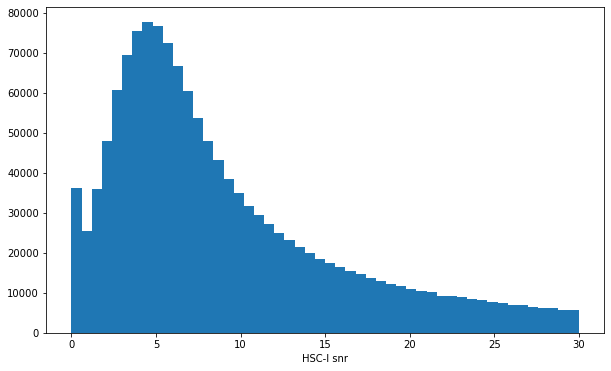

In [78]:
# hsc_i_flux,hsc_i_fluxerr=mag_to_flux(
#     cat['HSC_I_m_base_CircularApertureFlux_6_0_mag'],cat['HSC_I_m_base_CircularApertureFlux_6_0_magErr'])
hsc_i_flux,hsc_i_fluxerr=(
    cat['HSC_I_m_base_CircularApertureFlux_6_0_flux'],cat['HSC_I_m_base_CircularApertureFlux_6_0_fluxErr'])
plt.hist(hsc_i_flux/hsc_i_fluxerr,bins=50,range=[0,30])
plt.xlabel('HSC-I snr')

/Users/raphaelshirley/miniconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/Users/raphaelshirley/miniconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


Text(0.5, 0, 'log10(VIRCAM_Y)')

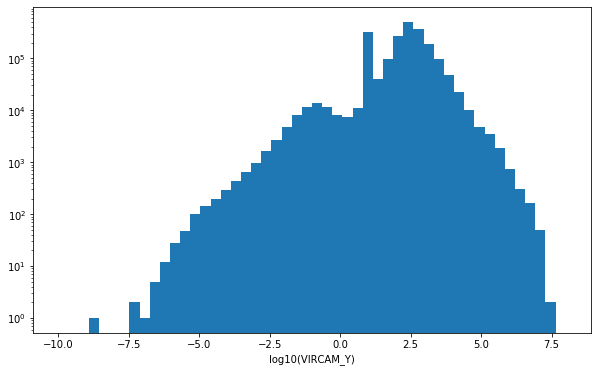

In [84]:
plt.hist(np.log10(cat['VIRCAM_Y_m_base_CircularApertureFlux_6_0_flux']),bins=50,range=[-10,8])
plt.yscale('log')
plt.xlabel('log10(VIRCAM_Y)')

In [85]:
np.sum(cat['VIRCAM_Y_m_base_CircularApertureFlux_6_0_flux']<0)

289413

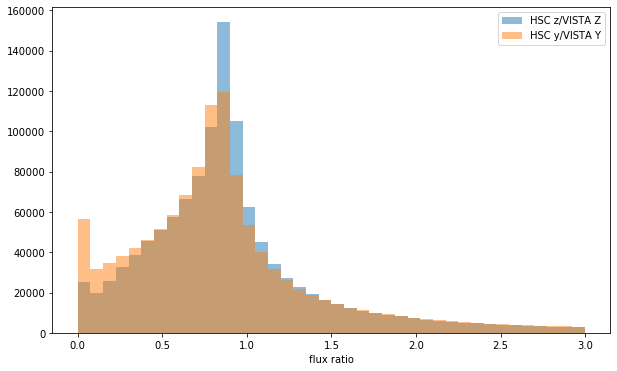

In [86]:
hsc_z_flux,hsc_z_fluxerr=(
    cat['HSC_Z_m_base_CircularApertureFlux_6_0_flux'],cat['HSC_Z_m_base_CircularApertureFlux_6_0_fluxErr'])
vircam_z_flux,vircam_z_fluxerr=(
    cat['VIRCAM_Z_m_base_CircularApertureFlux_6_0_flux'],cat['VIRCAM_Z_m_base_CircularApertureFlux_6_0_fluxErr'])
hsc_y_flux,hsc_y_fluxerr=(
    cat['HSC_Y_m_base_CircularApertureFlux_6_0_flux'],cat['HSC_Y_m_base_CircularApertureFlux_6_0_fluxErr'])
vircam_y_flux,vircam_y_fluxerr=(
    cat['VIRCAM_Y_m_base_CircularApertureFlux_6_0_flux'],cat['VIRCAM_Y_m_base_CircularApertureFlux_6_0_fluxErr'])
try:
    z_rat=hsc_z_flux/vircam_z_flux
    z_m=np.isfinite(z_rat)
    y_rat=hsc_y_flux/vircam_y_flux
    y_m=np.isfinite(y_rat)
    plt.hist(z_rat[z_m],bins=40,range=[0,3],alpha=0.5,label='HSC z/VISTA Z')
    plt.hist(y_rat[y_m],bins=40,range=[0,3],alpha=0.5,label='HSC y/VISTA Y')
    plt.xlabel('flux ratio')
    plt.legend()
    plt.savefig('./figs/flux_ratios.png')
except KeyError:
    print('No VISTA ZY bands')

/Users/raphaelshirley/miniconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/Users/raphaelshirley/miniconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.
/Users/raphaelshirley/miniconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


Text(0.5, 0, 'SNR')

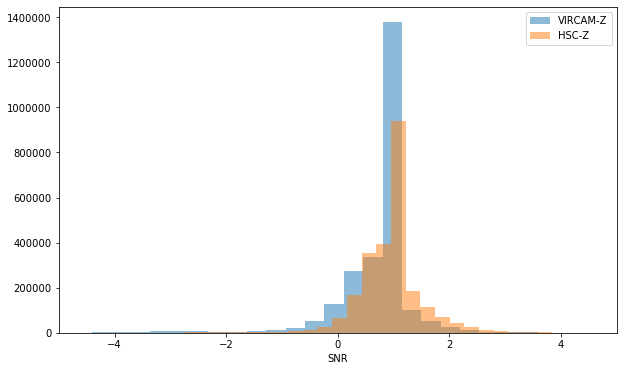

In [87]:
plt.hist(np.log10(vircam_z_flux/vircam_z_fluxerr),bins=100,alpha=0.5,label='VIRCAM-Z')
plt.hist(np.log10(hsc_z_flux/hsc_z_fluxerr),bins=100,alpha=0.5,label='HSC-Z')
plt.legend()
plt.xlim([-5,5])
plt.xlabel('SNR')

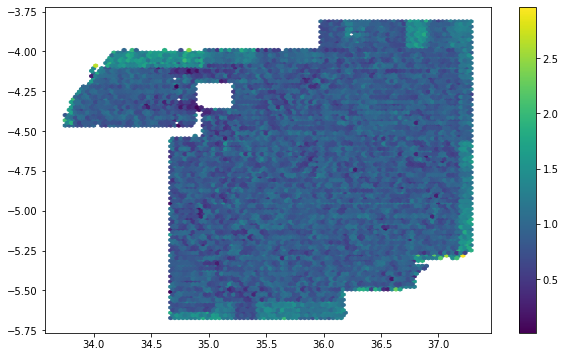

In [108]:
try:
    m=(y_rat>0) & (y_rat<3)
    plt.hexbin(cat[m]['ra'],cat[m]['dec'],C=y_rat[m], gridsize=100)
    plt.colorbar()
except NameError:
    print('No VISTA ZY bands')

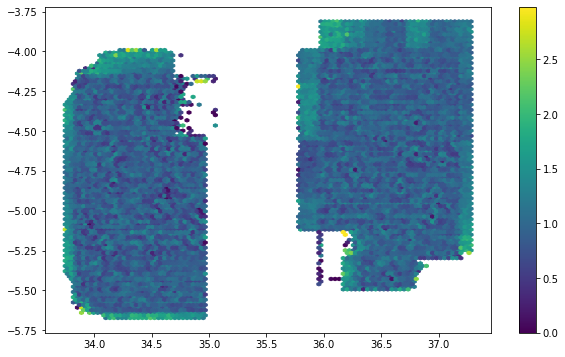

In [89]:
try:
    m=(z_rat>0) & (z_rat<3)
    plt.hexbin(cat[m]['ra'],cat[m]['dec'],C=z_rat[m], gridsize=100)
    plt.colorbar()
except NameError:
    print('No VISTA ZY bands')

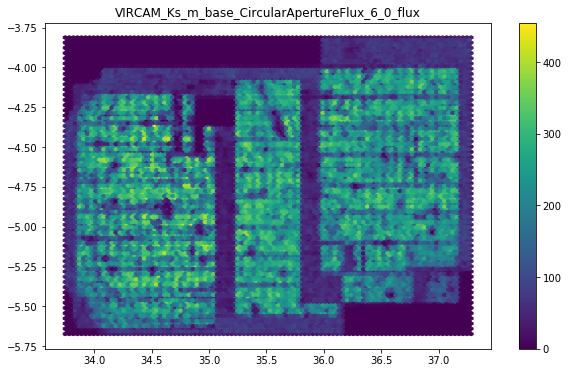

In [117]:
try:
    fluxCol='VIRCAM_Ks_m_base_CircularApertureFlux_6_0_flux'
    m=(cat[fluxCol]>0) #& (cat[fluxCol]<30)
    plt.hexbin(cat[m]['ra'],cat[m]['dec'], gridsize=100)
    plt.colorbar()
    plt.title(fluxCol)
except NameError:
    print('No data')

## Add EBV column

This is used to correct for galactic extinction.

In [90]:
cat.add_column(
    ebv(cat['ra'], cat['dec'])
)

## Write catalogue

In [91]:
cat[:5]

id,VIRCAM_Ks_m_coord_ra,VIRCAM_Ks_m_coord_dec,VIRCAM_Ks_m_detect_isPrimary,HSC_G_m_base_CircularApertureFlux_6_0_flux,HSC_R_m_base_CircularApertureFlux_6_0_flux,HSC_I_m_base_CircularApertureFlux_6_0_flux,HSC_Z_m_base_CircularApertureFlux_6_0_flux,HSC_Y_m_base_CircularApertureFlux_6_0_flux,VIRCAM_Z_m_base_CircularApertureFlux_6_0_flux,VIRCAM_Y_m_base_CircularApertureFlux_6_0_flux,VIRCAM_J_m_base_CircularApertureFlux_6_0_flux,VIRCAM_H_m_base_CircularApertureFlux_6_0_flux,VIRCAM_Ks_m_base_CircularApertureFlux_6_0_flux,HSC_G_m_base_CircularApertureFlux_6_0_fluxErr,HSC_R_m_base_CircularApertureFlux_6_0_fluxErr,HSC_I_m_base_CircularApertureFlux_6_0_fluxErr,HSC_Z_m_base_CircularApertureFlux_6_0_fluxErr,HSC_Y_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_Z_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_Y_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_J_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_H_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_Ks_m_base_CircularApertureFlux_6_0_fluxErr,ra,dec,specz_id,z_spec,zspec_qual,zspec_association_flag,ebv
,deg,deg,,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,deg,deg,,,,,
int64,float64,float64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,str25,float64,int64,bool,float64
3036468485870846118,34.116859550157464,-5.113130877627677,1,40.926807,54.322937,nan,78.63234,nan,53.245052,288.1231,102.502365,-745.7314,-53.526283,5.089149,7.3538694,nan,17.892424,nan,nan,nan,nan,nan,nan,34.116859550157464,-5.113130877627677,,-99.0,-99,False,0.019211495624006106
3036468485870846135,34.00439706836767,-5.1125861293942325,1,90.13256,127.69861,nan,233.85907,nan,110.863686,53.973984,187.87004,489.20932,654.87366,5.458248,7.8080306,nan,19.219131,nan,67.1147,106.271484,162.85979,260.28253,375.44168,34.00439706836767,-5.1125861293942325,,-99.0,-99,False,0.017543814826140293
3036468485870846144,34.10689001771839,-5.112357675424009,1,67.417046,62.366444,nan,71.16976,nan,168.5995,193.99483,323.7931,235.59041,397.25266,4.966421,7.2781134,nan,17.645796,nan,66.187096,104.127594,166.84364,261.53873,389.33383,34.10689001771839,-5.112357675424009,,-99.0,-99,False,0.019174222000565108
3036468485870846149,34.08977874881402,-5.11233286779129,1,32.083046,49.027245,nan,62.864662,nan,161.48962,259.9028,321.09332,14.913928,-28.920929,4.9667025,7.3326735,nan,17.750734,nan,66.39982,103.09934,167.65915,262.53928,390.83798,34.08977874881402,-5.11233286779129,,-99.0,-99,False,0.018907563885984465
3036468485870846152,34.02641913094855,-5.112035411116851,1,98.47988,85.468216,nan,78.35276,nan,-23.822863,74.27263,180.4475,564.6184,-239.93527,5.2032614,7.383944,nan,18.20245,nan,76.22194,112.88036,180.98985,281.699,422.03067,34.02641913094855,-5.112035411116851,,-99.0,-99,False,0.01785986280124196


In [92]:
for c in cat.colnames:
    if c.endswith('flux'):
        m=np.array(~np.isfinite(cat[c]))
        m|=np.array(cat[c])>1e18
        cat[c][m]=np.nan
        cat[c+'Err'][m]=np.nan

In [93]:
cat[0:5]

id,VIRCAM_Ks_m_coord_ra,VIRCAM_Ks_m_coord_dec,VIRCAM_Ks_m_detect_isPrimary,HSC_G_m_base_CircularApertureFlux_6_0_flux,HSC_R_m_base_CircularApertureFlux_6_0_flux,HSC_I_m_base_CircularApertureFlux_6_0_flux,HSC_Z_m_base_CircularApertureFlux_6_0_flux,HSC_Y_m_base_CircularApertureFlux_6_0_flux,VIRCAM_Z_m_base_CircularApertureFlux_6_0_flux,VIRCAM_Y_m_base_CircularApertureFlux_6_0_flux,VIRCAM_J_m_base_CircularApertureFlux_6_0_flux,VIRCAM_H_m_base_CircularApertureFlux_6_0_flux,VIRCAM_Ks_m_base_CircularApertureFlux_6_0_flux,HSC_G_m_base_CircularApertureFlux_6_0_fluxErr,HSC_R_m_base_CircularApertureFlux_6_0_fluxErr,HSC_I_m_base_CircularApertureFlux_6_0_fluxErr,HSC_Z_m_base_CircularApertureFlux_6_0_fluxErr,HSC_Y_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_Z_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_Y_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_J_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_H_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_Ks_m_base_CircularApertureFlux_6_0_fluxErr,ra,dec,specz_id,z_spec,zspec_qual,zspec_association_flag,ebv
,deg,deg,,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,deg,deg,,,,,
int64,float64,float64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,str25,float64,int64,bool,float64
3036468485870846118,34.116859550157464,-5.113130877627677,1,40.926807,54.322937,nan,78.63234,nan,53.245052,288.1231,102.502365,-745.7314,-53.526283,5.089149,7.3538694,nan,17.892424,nan,nan,nan,nan,nan,nan,34.116859550157464,-5.113130877627677,,-99.0,-99,False,0.019211495624006106
3036468485870846135,34.00439706836767,-5.1125861293942325,1,90.13256,127.69861,nan,233.85907,nan,110.863686,53.973984,187.87004,489.20932,654.87366,5.458248,7.8080306,nan,19.219131,nan,67.1147,106.271484,162.85979,260.28253,375.44168,34.00439706836767,-5.1125861293942325,,-99.0,-99,False,0.017543814826140293
3036468485870846144,34.10689001771839,-5.112357675424009,1,67.417046,62.366444,nan,71.16976,nan,168.5995,193.99483,323.7931,235.59041,397.25266,4.966421,7.2781134,nan,17.645796,nan,66.187096,104.127594,166.84364,261.53873,389.33383,34.10689001771839,-5.112357675424009,,-99.0,-99,False,0.019174222000565108
3036468485870846149,34.08977874881402,-5.11233286779129,1,32.083046,49.027245,nan,62.864662,nan,161.48962,259.9028,321.09332,14.913928,-28.920929,4.9667025,7.3326735,nan,17.750734,nan,66.39982,103.09934,167.65915,262.53928,390.83798,34.08977874881402,-5.11233286779129,,-99.0,-99,False,0.018907563885984465
3036468485870846152,34.02641913094855,-5.112035411116851,1,98.47988,85.468216,nan,78.35276,nan,-23.822863,74.27263,180.4475,564.6184,-239.93527,5.2032614,7.383944,nan,18.20245,nan,76.22194,112.88036,180.98985,281.699,422.03067,34.02641913094855,-5.112035411116851,,-99.0,-99,False,0.01785986280124196


In [94]:
np.sum(cat['zspec_qual']>0)

69281

In [95]:
np.sum(cat['zspec_qual']>=4 )/np.sum(cat['zspec_qual']>0)

0.2224996752356346

In [96]:
np.sum(cat['zspec_qual']>=3 )/np.sum(cat['zspec_qual']>0)

0.5514065905515221

In [97]:
for n in np.unique(cat['zspec_qual']):
    print('Flag: {}, fraction of objects: {}')

Flag: {}, fraction of objects: {}
Flag: {}, fraction of objects: {}
Flag: {}, fraction of objects: {}
Flag: {}, fraction of objects: {}
Flag: {}, fraction of objects: {}
Flag: {}, fraction of objects: {}


In [119]:
SUFFIX

'20220802T124445'

In [118]:
n='./data/lsst_ir_fusion_sxds_photoz_input_{}.fits'.format(SUFFIX)
cat.write(n,overwrite=True)
print(n)

./data/lsst_ir_fusion_sxds_photoz_input_20220802T124445.fits


In [120]:
len(cat),np.sum(cat['z_spec']>=0)

(2466951, 68117)

In [121]:
n='./data/lsst_ir_fusion_sxds_photoz_input_specz_sample_{}_{}.fits'.format(version,SUFFIX)
print(n)
cat[cat['z_spec']>=0].write(n,overwrite=True)


./data/lsst_ir_fusion_sxds_photoz_input_specz_sample_p2022p3_20220802T124445.fits


## Make res file

Eazy requires the filter transmission curves to be a single res file. Here we download the files from the Spanish Virtual Observatory and put them in a single file. We also label the bands according the order of the filter in the res file

Subaru/HSC.g Subaru HSC.g
Subaru/HSC.r Subaru HSC.r
Subaru/HSC.i Subaru HSC.i
Subaru/HSC.z Subaru HSC.z
Subaru/HSC.Y Subaru HSC.Y
Paranal/VISTA.J Paranal VISTA.J
Paranal/VISTA.H Paranal VISTA.H
Paranal/VISTA.Ks Paranal VISTA.Ks


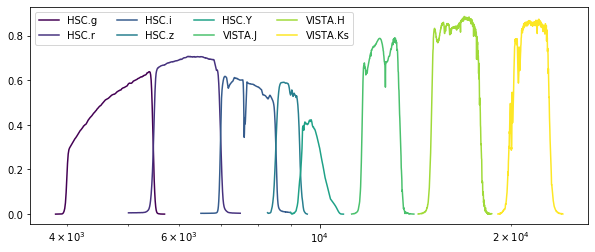

g
r
i
z
Y
J
H
Ks


In [30]:
import numpy as np
from urllib.request import urlretrieve
import os
import matplotlib.pyplot as plt

svo_path = 'http://svo2.cab.inta-csic.es/theory/fps3/getdata.php?format=ascii&id=format=ascii&id={0}'

# filter_names = ['BOK/BASS.g', 'BOK/BASS.r', 'KPNO/MzLS.z',
#                 'UKIRT/UKIDSS.J', 'UKIRT/UKIDSS.K',
#                 'WISE/WISE.W1', 'WISE/WISE.W2']
filter_names = [
    'Subaru/HSC.g',
    'Subaru/HSC.r',
    'Subaru/HSC.i',
    'Subaru/HSC.z',
    'Subaru/HSC.Y',
   # 'Paranal/VISTA.Z',
   # 'Paranal/VISTA.Y',
    'Paranal/VISTA.J',
    'Paranal/VISTA.H',
    'Paranal/VISTA.Ks',
]

colors = plt.cm.viridis(np.linspace(0, 1, len(filter_names)))

Fig, Ax = plt.subplots(1,1, figsize=(10, 4))

for i, filt in enumerate(filter_names):
    
    tlscp, name = os.path.split(filt)
    print(filt,tlscp,name)
    filter_lib, info = urlretrieve(svo_path.format(filt), f'data/{name}.dat')

    wave, response = np.loadtxt(f'data/{name}.dat').T

    Ax.semilogx(wave, response, color=colors[i], label=f'{name}')

Leg = Ax.legend(loc='upper left', ncol=4)
plt.show()


output_path = 'data/sxds_filters.res'
combined = open(output_path,'w')
combined_info = open(output_path+'.info','w')
translate = open('data/sxds.translate', 'w')
eazy_trnslate='data/testing/eazy/training_subset1_calc_zp.eazy.translate' #Do I also need to write this?

for ifx, filt in enumerate(filter_names):
    tlscp, name = os.path.split(filt)
    band = name.split('.')[-1]
    data = np.loadtxt(f'data/{name}.dat', ndmin=2, skiprows=0)
    name_lower=name.lower().replace('.','_')
    print(band)


    
    
    combined.write( '{0:>8d} {1:s} 0 0 0 {2}'.format(int(len(data[:,0])), name_lower, '\n'))
    ifx+=1 #Use 1 indexing
    translate.write(f'{name_lower:s}_flux F{ifx:.0f}\n')
    translate.write(f'{name_lower:s}_fluxerr E{ifx:.0f}\n')

    nums = range(1,len(data[:,0])+1)
    wave = data[:,0]
    resp = data[:,1]

    worder = np.argsort(wave)
    wave = wave[worder]
    resp = resp[worder]

    for i in range(len(nums)):
        combined.write('{0:>8d} {1:>10.2f} {2:>12.8g} {3}'.format(int(nums[i]), wave[i], resp[i],'\n'))

combined.close()
combined_info.close()
translate.close()

In [31]:
!ls data

HSC.Y.dat
HSC.g.dat
HSC.i.dat
HSC.r.dat
HSC.z.dat
VISTA.H.dat
VISTA.J.dat
VISTA.Ks.dat
VISTA.Y.dat
VISTA.Z.dat
XMM-LSS-specz-v2.91.fits.gz
XMM-LSS-specz-v2.91.fits.gz.1
XMM-LSS-specz-v2.91.fits.gz.2
XMM-LSS.translate
eazy.zphot.zeropoint
full
full_reduced_cat_SXDS.fits
lsst_ir_fusion_sxds_photoz_input_20211011.fits
lsst_ir_fusion_sxds_photoz_input_20211018.fits
lsst_ir_fusion_sxds_photoz_input_20220119.fits
lsst_ir_fusion_sxds_specz_cigale_input_20210906.fits
sxds.translate
sxds.translate.eazy
sxds.translate.opt
sxds_filters.res
sxds_filters.res.info
testing


In [32]:
!mkdir -p data/testing/all_specz/

In [33]:
!ls data/testing/all_specz/

In [34]:
!cp data/sxds.translate data/testing/eazy/training_subset1_calc_zp.eazy.translate
!cp data/sxds.translate data/testing/eazy/zphot.translate

## Troubleshooting

Here I am loading some eazy output files to check the runs have progressed properly

In [31]:
inCat=Table.read('./data/testing/test_subset1.cat',format='ascii')

In [32]:
inCat

help_id,ra,dec,VISTA_Ks_m_detect_isPrimary,hsc_g_flux,hsc_r_flux,hsc_i_flux,hsc_z_flux,hsc_y_flux,vista_z_flux,vista_y_flux,vista_j_flux,vista_h_flux,vista_ks_flux,hsc_g_fluxerr,hsc_r_fluxerr,hsc_i_fluxerr,hsc_z_fluxerr,hsc_y_fluxerr,vista_z_fluxerr,vista_y_fluxerr,vista_j_fluxerr,vista_h_fluxerr,vista_ks_fluxerr,specz_id,z_spec,zspec_qual,zspec_association_flag,id,ebv
int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str24,float64,int64,str4,int64,float64
149940984795384280,34.07550074924483,-5.63786147015687,1,7.908911855784077,37.724888903945974,71.32971427834585,99.74206019180589,117.40106197113136,61.06424558897672,87.27580447200684,132.73155447859673,196.13805315489753,247.99742952619835,0.04336680535575246,0.07633462747352954,0.06154238812315937,0.11829435786263728,0.2562789379547039,0.01631740354432525,0.02660168944989076,0.037652646404786064,0.06915811945471749,0.1048592132537531,OzDES_001924,0.41443,4,-99.,1136,0.018948701557299608
149940984795385433,33.974289506100575,-5.624719662050599,1,4.841381267880638,8.742802848569418,15.964675538011132,20.83329882490653,21.549333792747866,17.18270764697099,15.327394617231416,22.70089257630639,27.806581054683257,35.61910970651612,0.03139931947061269,0.05923004843564103,0.05811444253499859,0.1344021711642962,0.2782889716130721,0.01663678153101322,0.024971104607328477,0.04180113299944669,0.06809088657120087,0.09984759840194324,VIPERS-104244251,0.754,5,-99.,1690,0.019240414965051512
149940984795385596,34.039995393991326,-5.62356394973761,1,1.1943786148071447,4.276478531525286,7.47269580894331,11.14584763073,13.731868515221773,9.217685074500993,10.401736567966653,17.05100284369908,26.008630328755444,33.65108531061143,0.030113238025826612,0.05419119431519708,0.04968346869611205,0.11019564092795897,0.2556553135676168,0.014142632362258713,0.023950925823982786,0.039426812638211135,0.06758627260322424,0.09480807085269452,VIPERS-105213367,-99.0,2,-99.,1776,0.018738686766688554
149940984795386064,34.006191856818674,-5.617014471274209,1,1.5929554607870997,2.614422553337705,4.265921655984726,4.842662563774508,5.0473410560571015,4.400140274385822,4.2631261328993375,5.227003042783972,5.812564223368791,7.910636916223798,0.021431836259945228,0.03835640699774774,0.03379723418463301,0.07345700876558742,0.17467576420227166,0.011842603606380236,0.020010956409871165,0.030900298995427466,0.04904182055952138,0.08148979962077231,VIPERS-104245982,0.6642,5,-99.,2044,0.019071748949289723
149940984795386290,33.951701730318206,-5.612986792206975,1,1.1167488050400334,2.6063109001876015,5.625021228253398,7.717317792723423,10.243098943216781,7.045876861589113,7.848407603428786,11.785392928297263,14.631982685551181,20.922884868518086,0.02580289823974449,0.042984003461011215,0.036598858479957475,0.07576595059874973,0.21116613494034284,0.012466654943124197,0.02067887939089304,0.03254596331835744,0.04894340399191531,0.0777009226238694,VIPERS-104247023,0.6792,3,-99.,2172,0.019732415603949262
149940984795386352,33.97958356307133,-5.610615485778174,1,1.5801420990023245,2.075750621239791,4.208263290414075,4.759605442006665,6.9130508571528395,4.6392950079612945,4.521094603584935,6.7500648687997185,6.705387925849729,8.922399116654407,0.022824714760490895,0.036272810517098554,0.0369432821781874,0.08138828462384115,0.17144524220302212,0.011903755529366476,0.01979337020656227,0.030343273744396142,0.04904554808540555,0.0785295494462454,VIPERS-104247541,0.9308,4,-99.,2210,0.01940265909936616
149940984795386435,34.000510780171915,-5.609423061408273,1,1.429989523256333,3.4765521754790973,5.768251020403746,7.579974214851511,8.850795954700711,7.011891252438818,7.9541400832777915,9.436668905428382,12.181081059875318,15.294357112654763,0.02050851007291134,0.035954173531347784,0.033848241088683305,0.06917263379873462,0.17892552411494675,0.011439940158712261,0.018370151709352384,0.028573837684675

In [ ]:
441 in inCat['id']

In [33]:
outCat=Table.read('./data/testing/eazy/no_zp/test_subset1_no_zp.eazy.zout',format='ascii')

In [34]:
outCat

id,z_spec,z_a,z_m1,chi_a,l68,u68,l95,u95,l99,u99,nfilt,q_z,z_peak,peak_prob,z_mc
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1153,0.6634,0.417,0.758,42.17579,0.7,0.766,0.411,0.78,0.407,4.245,10,23.6769,0.7449,0.859,0.7403
1621,0.4885,3.897,3.78,44.59462,3.797,3.98,0.452,4.06,0.429,4.141,10,24.4773,3.8962,0.966,3.7758
1984,0.4604,0.469,0.508,45.06087,0.443,0.474,0.428,0.484,0.406,4.392,10,26.2545,0.4585,0.987,0.4684
2199,0.7003,0.408,0.41,19.18601,0.403,0.415,0.399,0.419,0.396,0.422,10,0.0711638,0.4092,1.0,0.4096
2202,0.6986,0.872,0.795,20.41487,0.718,0.88,0.409,0.893,0.4,0.916,10,2.48553,0.8265,0.921,0.8824
2342,0.7803,2.554,2.421,99.54666,2.241,2.559,2.137,2.585,2.004,2.602,10,8.9433,2.421,0.999,2.3774
2424,0.6009,0.434,0.448,21.25513,0.43,0.467,0.42,0.475,0.411,0.482,10,0.224935,0.4481,1.0,0.4553
2436,0.5364,0.43,0.436,11.78253,0.423,0.453,0.417,0.475,0.415,0.484,10,0.135143,0.4357,1.0,0.4221
3164,0.7003,0.878,0.867,12.60338,0.856,0.904,0.754,0.931,0.423,0.95,10,0.967002,0.8757,0.98,0.8906


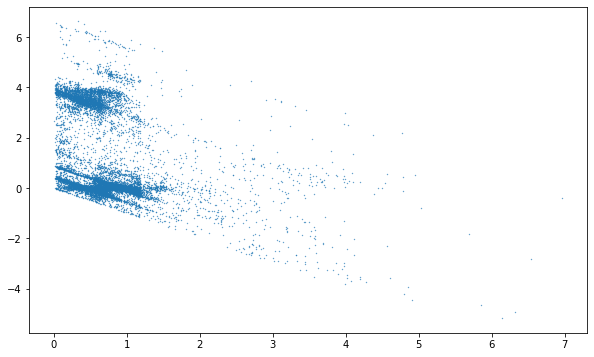

In [45]:
m=(outCat['z_peak']>0) & (outCat['z_spec']>0)
plt.scatter(outCat[m]['z_spec'],outCat[m]['z_peak']-outCat[m]['z_spec'],s=0.1)

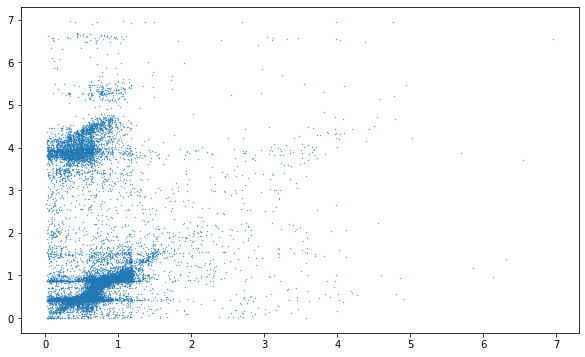

In [44]:
m=(outCat['z_peak']>0) & (outCat['z_spec']>0)
plt.scatter(outCat[m]['z_spec'],outCat[m]['z_peak'],s=0.1)

Text(0, 0.5, 'photoz z_peak')

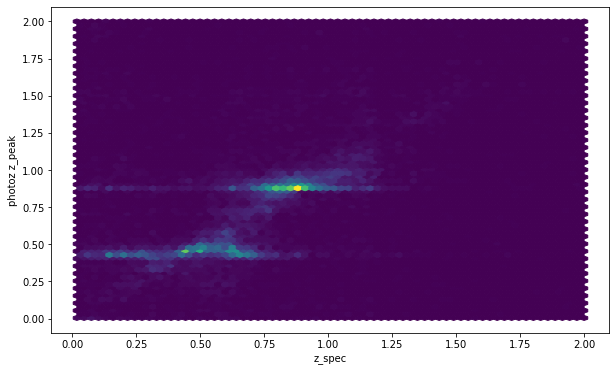

In [54]:
m2=(outCat['z_peak']>0) & (outCat['z_spec']>0)&(outCat['z_peak']<2) & (outCat['z_spec']<2)
plt.hexbin(outCat[m2]['z_spec'],outCat[m2]['z_peak'], gridsize=70)
plt.xlabel('z_spec')
plt.ylabel('photoz z_peak')

Text(0, 0.5, 'photoz z_peak - zspec')

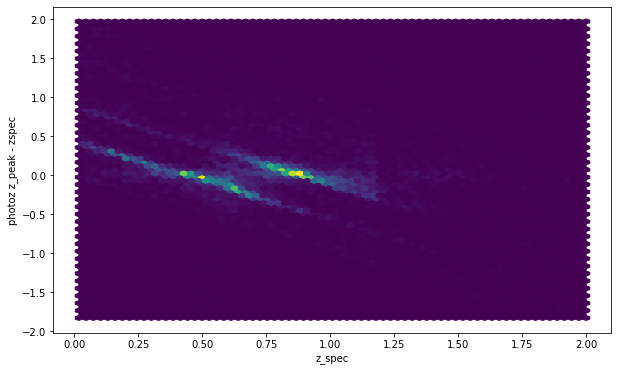

In [55]:
m2=(outCat['z_peak']>0) & (outCat['z_spec']>0)&(outCat['z_peak']<2) & (outCat['z_spec']<2)
plt.hexbin(outCat[m2]['z_spec'],outCat[m2]['z_peak']-outCat[m2]['z_spec'], gridsize=70)
plt.xlabel('z_spec')
plt.ylabel('photoz z_peak - zspec')

### Make a small catalogue for testing

In [7]:
!ls data

HSC.Y.dat
HSC.g.dat
HSC.i.dat
HSC.r.dat
HSC.z.dat
VISTA.H.dat
VISTA.J.dat
VISTA.Ks.dat
VISTA.Y.dat
VISTA.Z.dat
XMM-LSS-specz-v2.91.fits.gz
XMM-LSS-specz-v2.91.fits.gz.1
XMM-LSS-specz-v2.91.fits.gz.2
XMM-LSS.translate
eazy.zphot.zeropoint
full
full_reduced_cat_SXDS.fits
lsst_ir_fusion_sxds_photoz_input_20211011.fits
lsst_ir_fusion_sxds_photoz_input_20211018.fits
lsst_ir_fusion_sxds_photoz_input_20220119.fits
lsst_ir_fusion_sxds_specz_cigale_input_20210906.fits
sxds.translate
sxds.translate.eazy
sxds.translate.opt
sxds_filters.res
sxds_filters.res.info
testing


In [12]:
test_cat=Table.read('../../dmu5/dmu5_VIDEO/data/full_reduced_cat_SXDS_p2022.1_20220428.fits')

In [13]:
#From email from Manda
oxfordApCorr = {
    'HSC_G_2as':0.1765,
    'HSC_G_3as':0.0788,
    'HSC_R_2as':0.1638,
    'HSC_R_3as':0.0905,
    'HSC_I_2as':0.1512,
    'HSC_I_3as':0.0788,
    'HSC_Z_2as':0.2155,
    'HSC_Z_3as':0.1144,
    'HSC_Y_2as':0.2023,
    'HSC_Y_3as':0.1144,
    'VIRCAM_Z_2as':0.3567,
    'VIRCAM_Z_3as':0.2023,
    'VIRCAM_Y_2as':0.3567,
    'VIRCAM_Y_3as':0.2023,
    'VIRCAM_J_2as':0.2980,
    'VIRCAM_J_3as':0.1765,
    'VIRCAM_H_2as':0.2423,
    'VIRCAM_H_3as':0.1512,
    'VIRCAM_Ks_2as':0.2288,
    'VIRCAM_Ks_3as':0.1388}

In [14]:
len(test_cat)

4107980

In [15]:
for c in test_cat.colnames:
    if c.endswith('_mag'):
        #print(c)
        physical_filter='{}_{}'.format(c.split('_')[0],c.split('_')[1])
        #print(np.nanmedian(test_cat[c]))
        test_cat[c]-=oxfordApCorr['{}_2as'.format(physical_filter)]
        #print(np.nanmedian(test_cat[c]))

In [ ]:
nb_merge_dist_plot(
    SkyCoord(test_cat['ra'], test_cat['dec']),
    SkyCoord(specz['ra'] * u.deg, specz['dec'] * u.deg)
)

In [18]:
for c in test_cat.colnames:
    if 'ra' in c:
        print(c)

VIRCAM_Ks_m_detect_isTractInner
VIRCAM_Ks_m_coord_ra
HSC_R_m_coord_ra


In [19]:
test_cat.colnames

['id',
 'VIRCAM_Z_m_slot_ModelFlux_magErr',
 'VIRCAM_Z_m_slot_ModelFlux_mag',
 'VIRCAM_Z_m_slot_ModelFlux_flag',
 'VIRCAM_Z_m_base_PsfFlux_magErr',
 'VIRCAM_Z_m_base_PsfFlux_mag',
 'VIRCAM_Z_m_base_PsfFlux_flag',
 'VIRCAM_Z_m_base_ClassificationExtendedness_value',
 'VIRCAM_Z_m_base_ClassificationExtendedness_flag',
 'VIRCAM_Z_m_base_CircularApertureFlux_9_0_magErr',
 'VIRCAM_Z_m_base_CircularApertureFlux_9_0_mag',
 'VIRCAM_Z_m_base_CircularApertureFlux_9_0_flag',
 'VIRCAM_Z_m_base_CircularApertureFlux_6_0_magErr',
 'VIRCAM_Z_m_base_CircularApertureFlux_6_0_mag',
 'VIRCAM_Z_m_base_CircularApertureFlux_6_0_flag',
 'VIRCAM_Z_m_base_CircularApertureFlux_12_0_magErr',
 'VIRCAM_Z_m_base_CircularApertureFlux_12_0_mag',
 'VIRCAM_Z_m_base_CircularApertureFlux_12_0_flag',
 'VIRCAM_Y_m_slot_ModelFlux_magErr',
 'VIRCAM_Y_m_slot_ModelFlux_mag',
 'VIRCAM_Y_m_slot_ModelFlux_flag',
 'VIRCAM_Y_m_base_PsfFlux_magErr',
 'VIRCAM_Y_m_base_PsfFlux_mag',
 'VIRCAM_Y_m_base_PsfFlux_flag',
 'VIRCAM_Y_m_base_Cl